<p align="center">
    <span style="color:chocolate; font-size:2.5em; font-weight:bold;">
        Schedule Generator of electric LCV
    </span>
</p>

<p align="center">
    <span style="font-size:1.5em; font-weight:bold;">
        Carolina Gil Ribeiro, Jagruti Thaku
    </span>
</p>

## 0. Importing dependencies

In [ ]:
import pandas as pd
import numpy as np
import xlsxwriter as xl
import matplotlib.pyplot as plt
import os
from glob import glob
from matplotlib import rcParams
from datetime import datetime
import datetime as dt
import math
from typing import Literal
import time
from matplotlib.ticker import MaxNLocator

from efleetscheduler.schedule_configure import scheduletype, vehicletype, companytype
from efleetscheduler.schedule_generator_2 import generate_schedules

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
notebook_dir = os.getcwd()

ModuleNotFoundError: No module named 'schedule_configure'

# <span style="color:chocolate;">1. SCHEDULE GENERATOR MODULE</span>

<span style="color:green">

## 1.1 Schedyle generator configurations
</span>

In this module, the only required input file is the Energy Consumption Factor.
This factor is used to adjust energy consumption values based on changes in temperature, accounting for environmental and operational variations.

The example uses hourly temperature data from the "Stockholm-Observatorielunden A" measurement station, provided by the Swedish Meteorological and Hydrological Institute (SMHI).

In [ ]:
# environment arguments - adjust settings if necessary
env_config = {"original_seed": 42,  # Seed for RNG - can be set to None so always random (not recommended)
                    
              # settings below if you want to generate new schedules
              "gen_start_date": "2026-01-01 00:00:00",  # New schedule, start date
              "gen_end_date": "2026-01-14 23:00:00",  # New schedule, end date
              "freq": "h",  # 'h' means hourly frequency. .
              
              "EVs": 50, # Number of electric vehicles in the fleet
                            
              # path to the CSV file with energy consumption factor (the example if for Stockholm 2026)
              # This value can be adjusted to other locations with hourly temperature data
              "consumption_factor_file" : os.path.join(notebook_dir, "data", "Input", "Energy_consumption_factor_2026.csv")  
                                         
              }

<span style="color:green">

## 1.2. Fleet parameters configurations

</span>


It is possible to generate diferent types of schedules, adjusting different parameters.
Schedule configuration includes: Type of schedule (a or b), Type of vehicle (Catefory 1 - Renault and Category 2 - Toyota) and Company type.

New fleet parameters can be defined/created in the file "schedule_configure.py".

#### Type of Schedule
Schedules are categorised into two types: Type A, which consists of a continuous schedule, and Type B, which includes breaks. Various parameters are established to facilitate realistic modelling of daily logistics schedules, including mean departure and return times, standard deviations, and allowable time ranges.
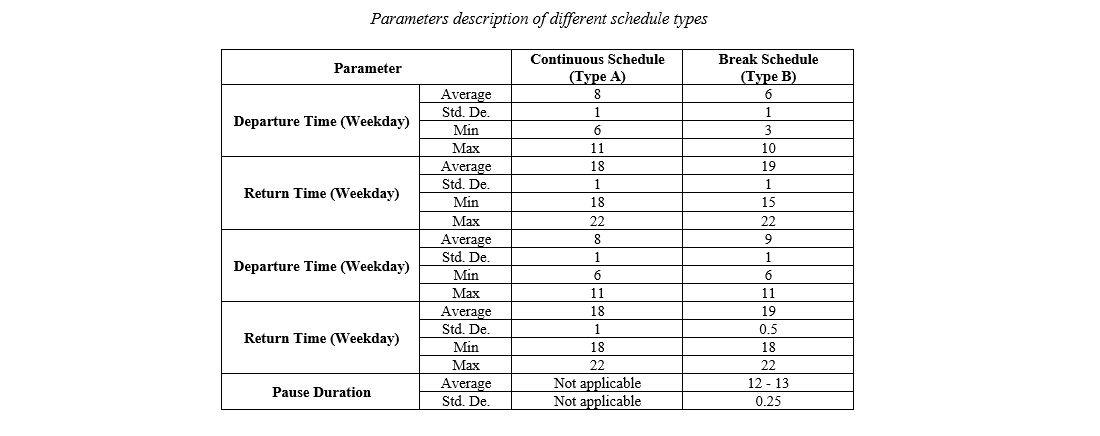

#### Type of vehicle: n_Renault and n_toyota

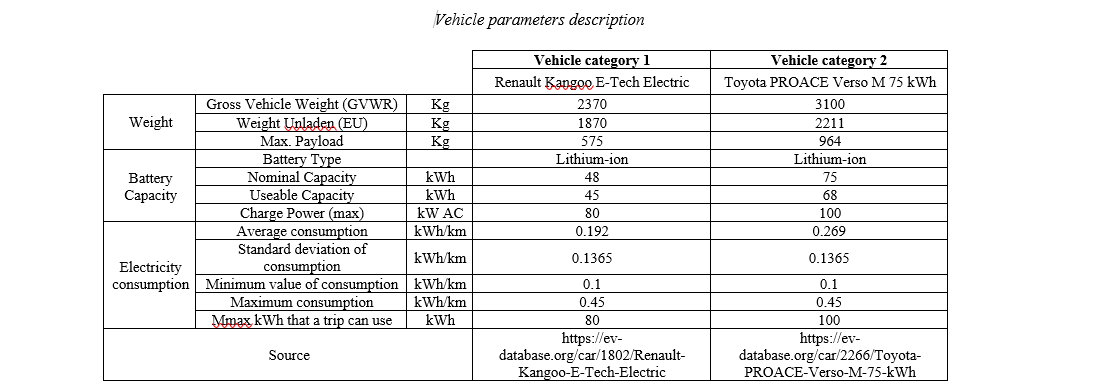

#### Company type
The values related to company type are defined based on the findings of a survey on light goods vehicles in Sweden conducted by Transport Analysis in 2022. 

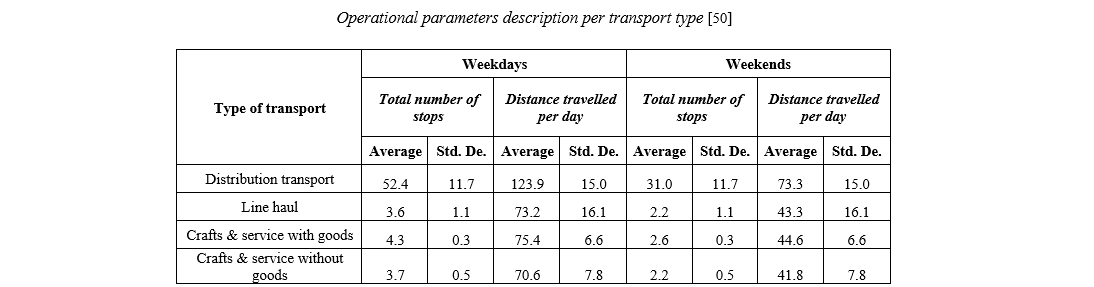

notes: Type of transport is defined as the primary use of the LCV and are described as follows: distribution transport for goods or commodities transports with several stops for loading and unloading along the way; Line haul goods or commodities transports, directly from one place to another;  Crafts and services with goods transports include trips for craft or service vehicle that include goods or merchandise to be used or installed in the work; and crafts and services without goods correspond to craft or service trips without goods or merchandise.

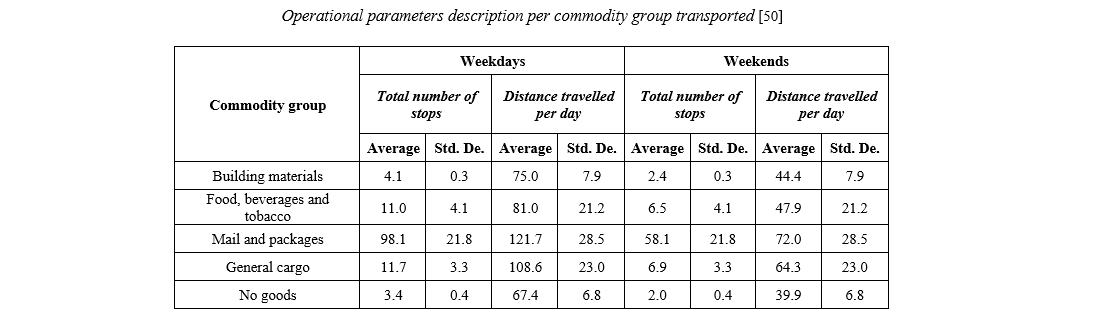

notes: Commodity groups were formulated in Light Goods Vehicles 2022 survey to capture the type of goods commonly transported identified by the vehicles.

### Schedule generator configurations

In [ ]:
# Schedule arguments - adjust settings if necessary
sch_config = {"Vehicles number": 20,  # Number of vehicles in the fleet
              
              "Type of schedule": {"type a": 0, "type b": 0, "type c": 20},  # Type A, which consists of a continuous schedule, and Type B, which includes breaks, going to the distribution terminal durind the day. 
              
              # Type C is Costum Schedule that needs to be define here:
              
              "Costum schedule": {"average departure weekday": 8,  # Average departure time on a weekday in hours (0-23)
                                  "std deviation departure weekday": 1,  # Standard deviation of departure time on a weekday in hours
                                  "average return weekday": 18,  # Average return time on a weekday in hours (0-23)
                                  "std deviation return weekday": 1,  # Standard deviation of return time on a weekday in hours
                                  "average departure weekend": 9,  # Average departure time on a weekend in hours (0-23)
                                  "std deviation departure weekend": 1,  # Standard deviation of departure time on a weekend in hours
                                  "average return weekend": 19,  # Average return time on a weekend in hours (0-23)
                                  "std deviation return weekend": 1,  # Standard deviation of return time on a weekend in hours
                                  "minimum departure": 6,  # Minimum departure time in hours (0-23)
                                  "maximum departure": 11,  # Maximum departure time in hours (0-23)
                                  "minimum return": 18,  # Minimum return time in hours (0-23)
                                  "maximum return": 22  # Maximum return time in hours (0-23)
                                  },
              
              "Type of vehicle": {"Renault": 20, "Pegeaut": 0},  # Renault or Peugeut
              
              "Company type": companytype.Costum, # Types of company: Distribution, LineHaul, CraftServWithGoods, CraftServWithoutGoods, Food, Mail, Building, Highdistance, Generalcargo, Nogoods
              
              #"Company type":Costum,  # Custom company type, if you want to generate a custom schedule with your own distance and stops parameters
              "Costum Distance": {"average weekday":120,  # Average distance travelled on a weekday in km
                                "average weekend": 70,  # Average distance travelled on a weekend in km 
                                "standard deviation weekday": 15,  # Standard deviation of distance travelled on a weekday in km
                                "standard deviation weekend": 15,  # Standard deviation of distance travelled on a weekend in
                                "min distance": 30,  # Minimum distance travelled in km
                                "max distance": 300,  # Maximum distance travelled in km  
                                "min distance per hour": 1,  # Minimum distance travelled per hour in km
                                "max distance per hour": 50,  # Maximum distance travelled per hour in km
                                "average stops": 30,  # Average number of stops per day
                                "standard deviation stops": 10  # Standard deviation of number of stops per                  
                                },
              
              "Schedule name": 'Schedule_1'  # Name of the schedule:
                }

## 1.3. Schedule Generation

Define the vehicle fleet and type of schedule to generate in the following cell. It is possible to duplicate the cell and generate schedules for differents vehicle fleets.

In [ ]:
schedule_1 = generate_schedules(env_config, sch_config)

### Save parameters files in CVS

In [ ]:
# Save individual files for each parameter for both schedules
parameters = ['Distance_km', 'Consumption_kWh', 'Consumption_km', 'Location', 'ChargingStation', 'PowerRating_kW', 'ScheduleType', 'consumption_factor']

for schedule, schedule_name in zip([schedule_1], ['1']):
    for parameter in parameters:
        # Pivot the table for the current parameter
        pivoted_schedule = schedule.pivot_table(
            index='date', 
            columns='VehicleID', 
            values=parameter, 
            aggfunc='first'
        )

        # Flatten the multi-index columns
        pivoted_schedule.columns = [f'{parameter}_Vehicle_{vehicle}' for vehicle in pivoted_schedule.columns]
        
        # Reset the index to bring 'date' as a column
        pivoted_schedule.reset_index(inplace=True)
        
        # Folder name
        folder_name = f'Schedule_{schedule_name}'

        # Create and check on the folder Output in data folder in the project root
        output_folder = os.path.join(notebook_dir, '..', 'data', 'Output', folder_name)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        # Save each parameter to a separate CSV file in the output_folder
        file_name = os.path.join(output_folder, f'{schedule_name}_all_vehicles_{parameter}.csv')
        pivoted_schedule.to_csv(file_name, index=False)

In [ ]:
print(schedule.head())

## 1.4. Schedules post-processing and visualisation

### Graphs generation per schedule
If you have more than one type of fleet, just need to add the folder name in the next cell.

In [ ]:
folders = ['Schedule_1']

for folder in folders:
    schedule_name = folder.split("_")[1]
    output_folder = os.path.join(notebook_dir, '..', 'data', 'Output', folder)
    distance_file_path = os.path.join(output_folder, f'{schedule_name}_all_vehicles_Distance_km.csv')
    charging_file_path = os.path.join(output_folder, f'{schedule_name}_all_vehicles_ChargingStation.csv')
    consumption_file_path = os.path.join(output_folder, f'{schedule_name}_all_vehicles_Consumption_kWh.csv')

    
    generate_graphs(distance_file_path, charging_file_path, consumption_file_path, folder, output_folder)
